In [1]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# MNIST 데이터셋 내려받기
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
x, y = mnist['data'], mnist['target']
x.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
some_digit = x[0]
some_digit_image = some_digit.reshape(28,28)

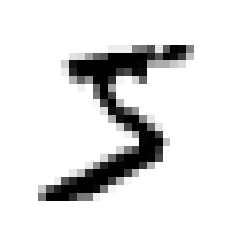

In [6]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

In [9]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [10]:
# 훈련데이터와 테스트 데이터 분류하기

In [11]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [12]:
x_train.shape

(60000, 784)

## 이진분류기 훈련

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier

In [15]:
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

In [16]:
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

## 성능검증

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [19]:
skfolds = StratifiedKFold(5, random_state=42)

/Users/methodfunc/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [20]:
for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    x_test_folds = x_train[test_index]
    y_train_folds = y_train_5[train_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_folds)
    n_connect = sum(y_pred == y_test_folds)
    
    print(n_connect / len(y_pred))

0.9546666666666667
0.96975
0.9635
0.9653333333333334
0.9484166666666667


In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
cross_val_score(sgd_clf, x_train, y_train_5, cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [23]:
from sklearn.base import BaseEstimator

In [24]:
class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        return self
    def predict(self, x):
        return np.zeros((len(x), 1), bool)

In [25]:
never_5_clf = Never5Classifier()

In [26]:
cross_val_score(never_5_clf, x_train, y_train_5, cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## 오차행렬

In [27]:
from sklearn.model_selection import cross_val_predict

In [28]:
# 예측값 만들기 ( 테스트 셋은 절대 하지 말아야한다.)
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=5)

In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
confusion_matrix(y_train_5, y_train_pred)

array([[53115,  1464],
       [  916,  4505]])

In [31]:
# 53115 와 916은 5가 아니라고 분류함
# 완벽한 분류기

In [32]:
y_train_perfect_predictions = y_train_5

In [33]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## 정밀도, 재현율

In [34]:
from sklearn.metrics import precision_score, recall_score

In [35]:
# 정밀도  ==  4505 / (4505+1464)
precision_score(y_train_5, y_train_pred)

0.7547327860613168

In [36]:
# 재현율 == 4505 / (4505+916)
recall_score(y_train_5, y_train_pred)

0.8310274857037447

In [37]:
# 정밀도 재현율의 조화평균 == F1 function
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.791044776119403

In [38]:
y_scores = sgd_clf.decision_function([some_digit])

In [39]:
y_scores

array([2164.22030239])

In [40]:
threshold = 0            # 임계값
y_some_digit_pred = (y_scores > threshold)

In [41]:
y_some_digit_pred

array([ True])

In [42]:
threshold = 2164
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [43]:
# 결정 함수를 반환하도록
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function")

In [44]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [45]:
# precision_recall_cureve() 로  모든 임계값(y_scores) 정밀도와 재현율을 계산 할 수 있다.
from sklearn.metrics import precision_recall_curve

In [46]:
precision, recalls, threshold = precision_recall_curve(y_train_5, y_scores)

In [47]:
recall_90_precision = recalls[np.argmax(precision >= 0.90)]
threshold_90_precision = threshold[np.argmax(precision >= 0.90)]

In [48]:
# 결점 임계값에 대한 정밀도와 재현율
def plot_presision_recall_vs_threshold(precision, recalls, threshold):
    plt.plot(threshold, precision[:-1], 'b--', label='Precision')
    plt.plot(threshold, recalls[:-1], 'g-', label='recalls')
    plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
    plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
    plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
    plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
    plt.xlim(-50000, 50000)
    plt.grid()

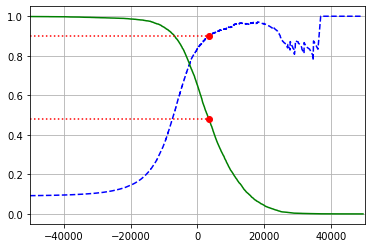

In [49]:
plot_presision_recall_vs_threshold(precision, recalls, threshold)
plt.show()

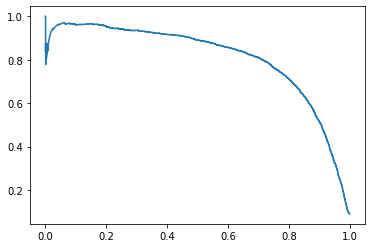

In [50]:
plt.plot(recalls, precision)

plt.show()

In [51]:
threshold_90_precision = threshold[np.argmax(precision >= 0.757325)]
threshold_90_precision

-2385.738051613958

In [52]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([ True, False, False, ...,  True, False, False])

In [53]:
precision_score(y_train_5, y_train_pred_90)

0.7573298912041305

In [54]:
recall_score(y_train_5, y_train_pred_90)

0.7576092971776425

## ROC곡선

In [55]:
from sklearn.metrics import roc_curve

In [56]:
fpr, tpr,thresholds = roc_curve(y_train_5, y_scores)

In [57]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99937705, 0.99937705,
       1.        ])

In [58]:
tpr

array([0.00000000e+00, 1.84467810e-04, 9.22339052e-04, ...,
       9.99815532e-01, 1.00000000e+00, 1.00000000e+00])

In [59]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, lw=2, label =label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0, 1, 0, 1])     
    plt.grid()

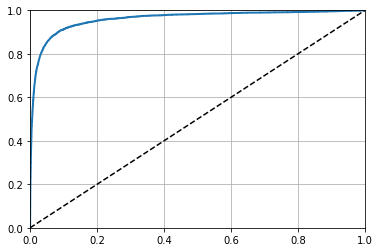

In [60]:
plot_roc_curve(fpr, tpr)

In [61]:
from sklearn.metrics import roc_auc_score

In [62]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
forest_clf = RandomForestClassifier(random_state= 42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method='predict_proba')

In [65]:
# 양성클래스에 대한 롹률을 점수로 사용합니다.
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [66]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

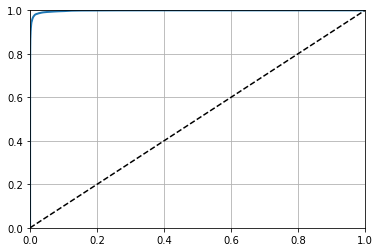

In [67]:
# 랜덤 포레스트 roc_곡선
plot_roc_curve(fpr_forest, tpr_forest)

In [68]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [69]:
# 정밀도 재현도를 계산하기 위한 훈련
y_train_pred_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3)

In [70]:
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [71]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## 다중분류기

In [72]:
from sklearn.svm import SVC

In [73]:
svc_clf = SVC()

In [74]:
svc_clf.fit(x_train, y_train)
svc_clf.predict([some_digit])

array([5], dtype=uint8)

In [75]:
some_digit_scores = svc_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [76]:
np.argmax(some_digit_scores)

5

In [77]:
svc_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### 강제 ovr

In [78]:
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
# OVR 강제로 하기 OVR<- 이진불류 알고리즘은 이것은 선호한다.
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(x_train, y_train)
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

In [ ]:
# 확률적 경사 하강법
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

In [ ]:
sgd_clf.decision_function([some_digit])

In [ ]:
# 정확도 평가
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

In [ ]:
# 입력스케일 조정 (standardscale)
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

## 에러분석

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)

In [ ]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/ row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)

In [ ]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
cl_a, cl_b = 3, 5

In [ ]:
x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(x_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(x_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(x_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(x_bb[:25], images_per_row=5)
plt.show()

## 3.6 다중레이블

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
knn_clf = KNeighborsClassifier()

In [ ]:
knn_clf.fit(x_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
y_tarin_kk_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)

In [ ]:
f1_score(y_multilabel, y_tarin_kk_pred, average='macro')

### 3.7 다중 출력 분류

In [ ]:
noise = np.random.randint(0, 100, (len(x_train), 784))

In [ ]:
x_train_mod = x_train + noise

In [ ]:
noise = np.random.randint(0, 100, (len(x_test), 784))

In [ ]:
x_test_mod = x_test + noise

In [ ]:
y_train_mod = x_train

In [ ]:
y_test_mod = x_test

In [ ]:
knn_clf.fit(x_train_mod, y_train_mod)

In [ ]:
some_index = 0
clean_digit = knn_clf.predict([x_test_mod[some_index]])

In [ ]:
plot_digits(clean_digit)